In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FastICA,FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, homogeneity_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
fig_path='D:/OMSCS/ml/Assignment3/figures/'

In [2]:
cancer = pd.read_csv('D:/OMSCS/ml/Assignment1/data/cancer.csv')
# drop un-needed columns
cancer.drop(['id'], axis=1, inplace=True)
cancer.drop(['Unnamed: 32'], axis=1, inplace=True)
# update target variable from text to binary expression (Malignant to 1; benign to 0)
cancer.loc[cancer['diagnosis'] == "M", 'diagnosis'] = 1
cancer.loc[cancer['diagnosis'] == "B", 'diagnosis'] = 0
# update the target column datatype from object to float otherwise cannot fit the data
cancer['diagnosis'] = cancer['diagnosis'].astype(float)

cancerX = cancer.drop(['diagnosis'], axis=1).copy().values
cancerY = cancer['diagnosis'].copy().values
cancer_x_df = cancer.drop('diagnosis',1)


consumer = pd.read_csv('D:/OMSCS/ml/Assignment1/data/consumercredit.csv')
consumer.drop(['Unnamed: 0'], axis=1, inplace=True)
id = 903657078
# Return a random sample from original dataset to reduce operation time.
consumer = consumer.sample(frac=0.05, random_state=id)
# split dataset into training and testing
consumerX = consumer.drop(['SeriousDlqin2yrs'], axis=1).copy().values
consumerY = consumer['SeriousDlqin2yrs'].copy().values
# resample the data due to extreme imblance
sm = SMOTE(sampling_strategy='minority', random_state=id)
consumerX, consumerY = sm.fit_resample(consumerX, consumerY)

cols = consumer.drop(['SeriousDlqin2yrs'], axis=1).copy().columns
consumer_x_df = pd.DataFrame(consumerX, columns = cols)

# normalize features for better performance 
min_max_scaler = preprocessing.MinMaxScaler()
cancerX = min_max_scaler.fit_transform(cancerX)
cancerX_df = pd.DataFrame(cancerX, columns=cancer_x_df.columns)
consumerX = min_max_scaler.fit_transform(consumerX)
consumerX_df = pd.DataFrame(consumerX, columns=consumer_x_df.columns)
consumer = pd.concat([consumerX_df, pd.DataFrame(consumerY, columns=['SeriousDlqin2yrs'])],axis=1)

# Cancer + RandomizedProjection (RP)

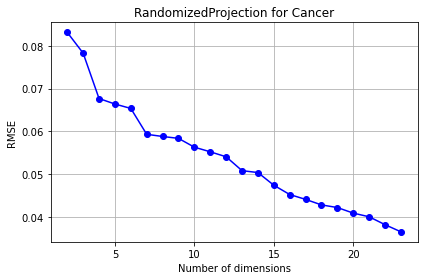

In [3]:
dims_cancer = list(range(2,24,1))
rc_errors = {}
for dim in dims_cancer:
    grp = GaussianRandomProjection(n_components=dim, random_state=id)
    
    # reconstruction
    x_prime = grp.fit_transform(cancerX_df.values)
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(cancerX_df.values, reconstructed)    
    rc_errors[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'o-', color='blue')
plt.xlabel("Number of dimensions")
plt.ylabel("RMSE")
plt.title('RandomizedProjection for Cancer')
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'rp_var_cancer.png')

In [4]:
comp = 20
grp = GaussianRandomProjection(n_components=comp, random_state=id)
grp_result = grp.fit_transform(cancerX_df.values)
for i in range(comp):
    field_name = "grp-"+str(i)
    cancerX_df[field_name] = grp_result[:,i]
    cancer[field_name] = grp_result[:,i]

cancerX_grp_20 = grp_result

In [5]:
cancerX_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,grp-10,grp-11,grp-12,grp-13,grp-14,grp-15,grp-16,grp-17,grp-18,grp-19
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,-0.641811,0.749184,-0.060645,-0.723883,-0.550841,-0.327728,-0.763821,0.186894,0.382476,-0.064721
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,-0.482001,0.373815,0.006106,-0.379435,-0.543780,0.098844,-0.190671,0.084364,0.251487,0.023978
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,-0.570573,0.589301,-0.052635,-0.344181,-0.508328,-0.078932,-0.402416,0.024724,0.398922,0.013285
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,-0.390849,1.253727,-0.034505,-0.708367,-0.493797,-0.257550,-1.512547,0.161424,0.160222,0.139328
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,-0.644550,0.319050,0.069523,-0.317143,-0.557603,-0.106453,-0.266725,0.002051,0.240223,0.064189


In [6]:
rndperm = np.random.permutation(cancer.shape[0])

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

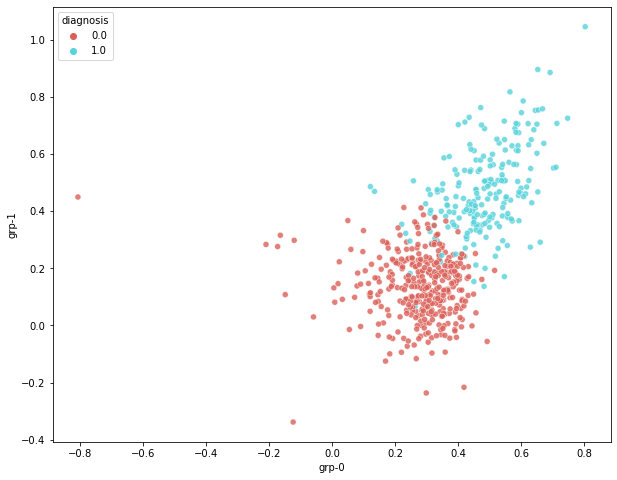

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="grp-0", y="grp-1",
    hue='diagnosis',
    palette=sns.color_palette("hls", 2),
    data=cancer,
    legend="full",
    alpha=0.8
)

Text(0.5, 0, 'grp-three')

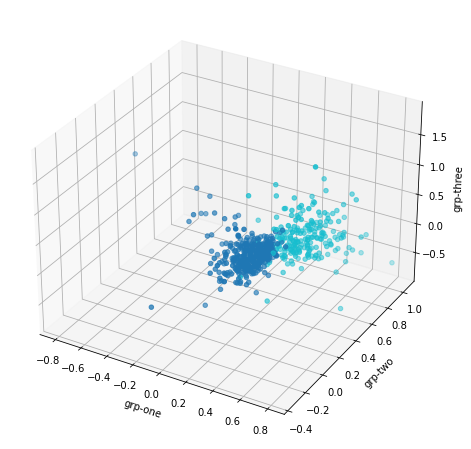

In [8]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(xs=cancer.loc[rndperm, "grp-0"], 
           ys=cancer.loc[rndperm, "grp-1"], 
           zs=cancer.loc[rndperm, "grp-2"], 
    c=cancer.loc[rndperm,:]["diagnosis"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')

## Cancer + RP + Kmean

In [9]:
clusters = list(range(2,31,1))

In [10]:
cancerX_grp_20.shape

(569, 20)

For n_clusters=2, Silhouette Coeff is 0.34 homogeneity_score is 0.61
For n_clusters=3, Silhouette Coeff is 0.34 homogeneity_score is 0.58
For n_clusters=4, Silhouette Coeff is 0.22 homogeneity_score is 0.64
For n_clusters=5, Silhouette Coeff is 0.18 homogeneity_score is 0.62
For n_clusters=6, Silhouette Coeff is 0.18 homogeneity_score is 0.68
For n_clusters=7, Silhouette Coeff is 0.19 homogeneity_score is 0.68
For n_clusters=8, Silhouette Coeff is 0.18 homogeneity_score is 0.68
For n_clusters=9, Silhouette Coeff is 0.18 homogeneity_score is 0.72
For n_clusters=10, Silhouette Coeff is 0.17 homogeneity_score is 0.7
For n_clusters=11, Silhouette Coeff is 0.16 homogeneity_score is 0.75
For n_clusters=12, Silhouette Coeff is 0.17 homogeneity_score is 0.8
For n_clusters=13, Silhouette Coeff is 0.13 homogeneity_score is 0.79
For n_clusters=14, Silhouette Coeff is 0.15 homogeneity_score is 0.74
For n_clusters=15, Silhouette Coeff is 0.16 homogeneity_score is 0.8
For n_clusters=16, Silhouette C

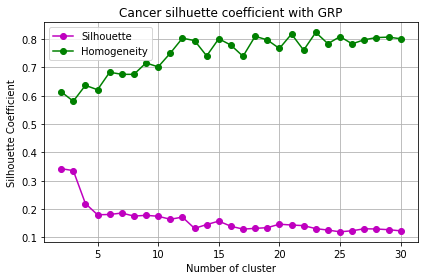

In [11]:
silh = {}
homog = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=500, random_state=id, n_jobs=-1).fit(cancerX_grp_20)
    label = kmeans.labels_
    sil_coeff = silhouette_score(cancerX_grp_20, label, metric='euclidean')
    homog_score = homogeneity_score(cancerY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog.keys()), list(homog.values()), 'o-', color='g', label="Homogeneity")
plt.title('Cancer silhuette coefficient with GRP')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'cancer_silhuette_coefficient_grp.png')

For n_clusters=2, Silhouette Coeff is 0.3 homogeneity_score is 0.68
For n_clusters=3, Silhouette Coeff is 0.27 homogeneity_score is 0.59
For n_clusters=4, Silhouette Coeff is 0.14 homogeneity_score is 0.66
For n_clusters=5, Silhouette Coeff is 0.11 homogeneity_score is 0.65
For n_clusters=6, Silhouette Coeff is 0.11 homogeneity_score is 0.73
For n_clusters=7, Silhouette Coeff is 0.06 homogeneity_score is 0.66
For n_clusters=8, Silhouette Coeff is 0.1 homogeneity_score is 0.77
For n_clusters=9, Silhouette Coeff is 0.1 homogeneity_score is 0.71
For n_clusters=10, Silhouette Coeff is 0.12 homogeneity_score is 0.72
For n_clusters=11, Silhouette Coeff is 0.08 homogeneity_score is 0.72
For n_clusters=12, Silhouette Coeff is 0.09 homogeneity_score is 0.75
For n_clusters=13, Silhouette Coeff is 0.09 homogeneity_score is 0.74
For n_clusters=14, Silhouette Coeff is 0.09 homogeneity_score is 0.72
For n_clusters=15, Silhouette Coeff is 0.09 homogeneity_score is 0.78
For n_clusters=16, Silhouette C

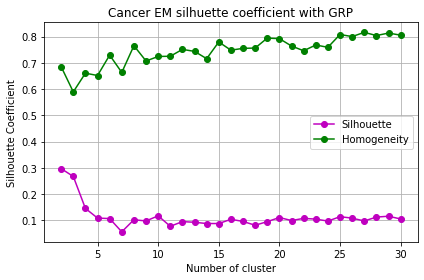

In [12]:
silh_EM = {}
homog_EM = {}
# log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=id, n_init=5).fit(cancerX_grp_20)
    label = gmm.predict(cancerX_grp_20)
    sil_coeff = silhouette_score(cancerX_grp_20, label, metric='euclidean')
    homog_score = homogeneity_score(cancerY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
#     log_likelihood_EM[cluster] = gmm.score(cancerX_grp_20)
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
#     print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_EM.keys()), list(homog_EM.values()), 'o-', color='g', label="Homogeneity")
plt.title('Cancer EM silhuette coefficient with GRP')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'cancer_EM_silhuette_coefficient_grp.png')

# Consumer + RP

In [13]:
dims_consumer = list(range(1,8,1))

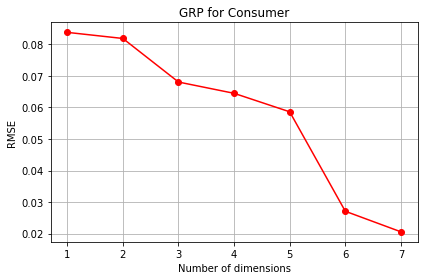

In [14]:
rc_errors_consumer = {}
for dim in dims_consumer:
    grp = GaussianRandomProjection(n_components=dim, random_state=id)
    x_prime = grp.fit_transform(consumerX_df.values)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(consumerX_df.values, reconstructed)    
    rc_errors_consumer[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors_consumer.keys()), list(rc_errors_consumer.values()), 'o-', color='red')
plt.xlabel("Number of dimensions")
plt.ylabel("RMSE")
plt.title('GRP for Consumer')
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'grp_var_consumer.png')

In [15]:
comp = 6
grp = GaussianRandomProjection(n_components=comp, random_state=id)
grp_result = grp.fit_transform(consumerX_df.values)
for i in range(comp):
    field_name = "grp-"+str(i)
    consumerX_df[field_name] = grp_result[:,i]
    consumer[field_name] = grp_result[:,i]
consumerX_grp_6 = grp_result

In [16]:
rndperm = np.random.permutation(consumer.shape[0])

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

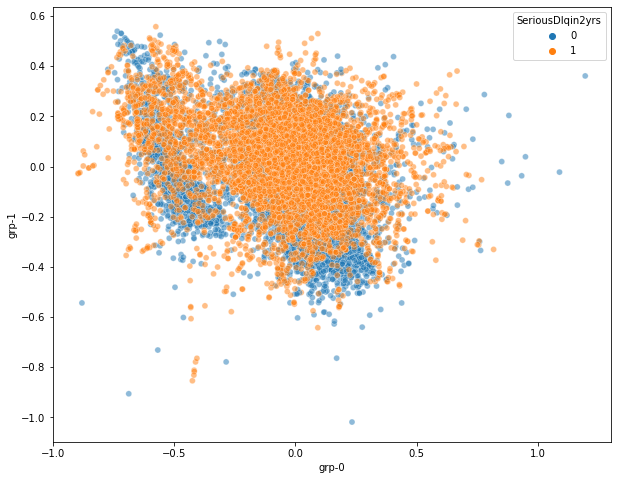

In [17]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="grp-0", y="grp-1",
    hue="SeriousDlqin2yrs",
    palette=sns.color_palette("tab10", 2),
    data=consumer,
    legend="full",
    alpha=0.5
)

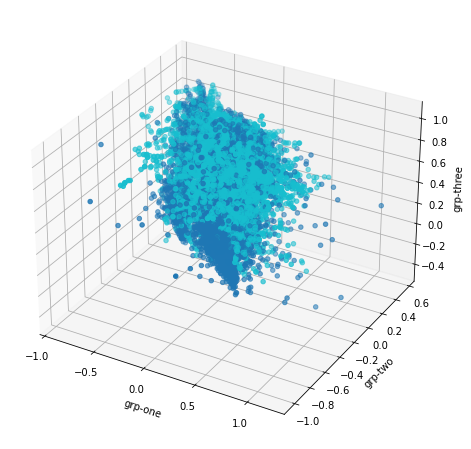

In [18]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(
    xs=consumer.loc[rndperm, "grp-0"], 
    ys=consumer.loc[rndperm, "grp-1"], 
    zs=consumer.loc[rndperm, "grp-2"], 
    c=consumer.loc[rndperm,:]["SeriousDlqin2yrs"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
plt.show()

# Consumer + GRP + Kmean

For n_clusters=2, Silhouette Coeff is 0.35 homogeneity_score is 0.16
For n_clusters=3, Silhouette Coeff is 0.36 homogeneity_score is 0.14
For n_clusters=4, Silhouette Coeff is 0.35 homogeneity_score is 0.16
For n_clusters=5, Silhouette Coeff is 0.31 homogeneity_score is 0.17
For n_clusters=6, Silhouette Coeff is 0.27 homogeneity_score is 0.18
For n_clusters=7, Silhouette Coeff is 0.26 homogeneity_score is 0.18
For n_clusters=8, Silhouette Coeff is 0.25 homogeneity_score is 0.18
For n_clusters=9, Silhouette Coeff is 0.25 homogeneity_score is 0.19
For n_clusters=10, Silhouette Coeff is 0.25 homogeneity_score is 0.19
For n_clusters=11, Silhouette Coeff is 0.24 homogeneity_score is 0.2
For n_clusters=12, Silhouette Coeff is 0.23 homogeneity_score is 0.2
For n_clusters=13, Silhouette Coeff is 0.21 homogeneity_score is 0.2
For n_clusters=14, Silhouette Coeff is 0.21 homogeneity_score is 0.2
For n_clusters=15, Silhouette Coeff is 0.21 homogeneity_score is 0.21
For n_clusters=16, Silhouette Co

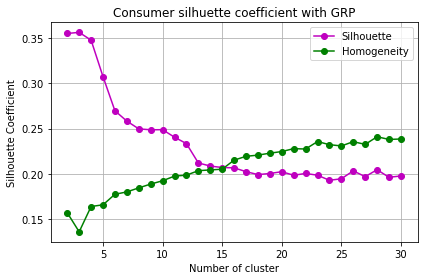

In [19]:
silh_consumer = {}
homog_consumer = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=500, random_state=id, n_jobs=-1).fit(consumerX_grp_6)
    label = kmeans.labels_
    sil_coeff = silhouette_score(consumerX_grp_6, label, metric='euclidean')
    homog_score = homogeneity_score(consumerY, label)
    silh_consumer[cluster] = sil_coeff
    homog_consumer[cluster] = homog_score
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
plt.figure()
plt.plot(list(silh_consumer.keys()), list(silh_consumer.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_consumer.keys()), list(homog_consumer.values()), 'o-', color='g', label="Homogeneity")
plt.title('Consumer silhuette coefficient with GRP')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'consumer_silhuette_coefficient_grp.png')

For n_clusters=2, Silhouette Coeff is 0.21 homogeneity_score is 0.16
For n_clusters=3, Silhouette Coeff is 0.27 homogeneity_score is 0.18
For n_clusters=4, Silhouette Coeff is 0.21 homogeneity_score is 0.24
For n_clusters=5, Silhouette Coeff is 0.06 homogeneity_score is 0.24
For n_clusters=6, Silhouette Coeff is 0.06 homogeneity_score is 0.24
For n_clusters=7, Silhouette Coeff is 0.05 homogeneity_score is 0.24
For n_clusters=8, Silhouette Coeff is 0.04 homogeneity_score is 0.25
For n_clusters=9, Silhouette Coeff is -0.02 homogeneity_score is 0.28
For n_clusters=10, Silhouette Coeff is -0.02 homogeneity_score is 0.29
For n_clusters=11, Silhouette Coeff is -0.02 homogeneity_score is 0.28
For n_clusters=12, Silhouette Coeff is -0.02 homogeneity_score is 0.29
For n_clusters=13, Silhouette Coeff is -0.01 homogeneity_score is 0.28
For n_clusters=14, Silhouette Coeff is -0.05 homogeneity_score is 0.3
For n_clusters=15, Silhouette Coeff is -0.05 homogeneity_score is 0.3
For n_clusters=16, Silh

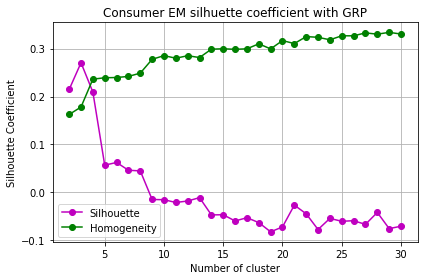

In [20]:
silh_consumer_EM = {}
homog_consumer_EM = {}
# log_likelihood_consumer_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=id, n_init=5).fit(consumerX_grp_6)
    label = gmm.predict(consumerX_grp_6)
    sil_coeff = silhouette_score(consumerX_grp_6, label, metric='euclidean')
    homog_score = homogeneity_score(consumerY, label)
    silh_consumer_EM[cluster] = sil_coeff
    homog_consumer_EM[cluster] = homog_score
#     log_likelihood_consumer_EM[cluster] = gmm.score(consumerX_grp_6)
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
#     print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_consumer_EM[cluster]))
plt.figure()
plt.plot(list(silh_consumer_EM.keys()), list(silh_consumer_EM.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_consumer_EM.keys()), list(homog_consumer_EM.values()), 'o-', color='g', label="Homogeneity")
plt.title('Consumer EM silhuette coefficient with GRP')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'consumer_EM_silhuette_coefficient_grp.png')

## Neural Network + GRP

In [21]:
cancerX_df.shape # this is the dimensionality reduction + clustering

(569, 50)

In [22]:
cancerX_grp_20.shape # this is the dimensionality reduction

(569, 20)

In [23]:
# neural nets with dimensionality reduction only
neural_net = MLPClassifier()
neural_net.fit(cancerX_grp_20, cancerY)

cancer_train_pred = neural_net.predict(cancerX_grp_20)
accuracy = accuracy_score(cancerY, cancer_train_pred)
print('The accuracy score for benchmark is', round(accuracy,4))
print()
print(classification_report(cancerY, cancer_train_pred))

The accuracy score for benchmark is 0.9772

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       357
         1.0       0.98      0.96      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.97      0.98       569
weighted avg       0.98      0.98      0.98       569



In [24]:
scores = cross_val_score(neural_net, cancerX_grp_20, cancerY, scoring="f1_weighted", cv=5)
scores, scores.mean()

(array([0.94710735, 0.97348086, 0.95577568, 0.96491228, 0.99117112]),
 0.9664894577140997)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(cancerX_grp_20, cancerY, test_size=0.2, random_state=id)

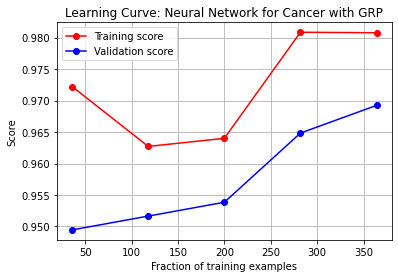

In [26]:
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(neural_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network for Cancer with GRP')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_GRP_learning_curve.png')

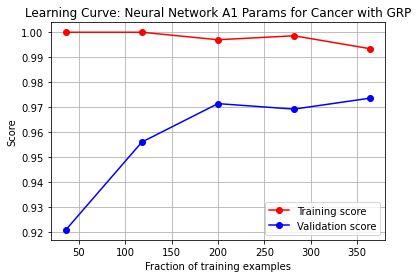

In [27]:
# use parameters from Assignment 1
best_net = MLPClassifier(activation='relu',
                         hidden_layer_sizes=(30,),
                         learning_rate_init=0.01, 
                         max_iter=500,
                         random_state=id, 
                         solver='adam',
                         alpha=0.0001)

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network A1 Params for Cancer with GRP')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_A1_params_GRP_learning_curve.png')

In [28]:
# check optimal parameters for nn & grp

param_grid = {'hidden_layer_sizes': [(15,), (15, 7), (30, ), (30, 15)],
              'alpha' : [0.1, 0.01, 0.001],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

search_f1 = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=4)
search_f1.fit(X_train, y_train)
print(search_f1.best_estimator_, search_f1.best_score_)

MLPClassifier(alpha=0.1, hidden_layer_sizes=(30, 15), learning_rate='adaptive') 0.9824175824175825


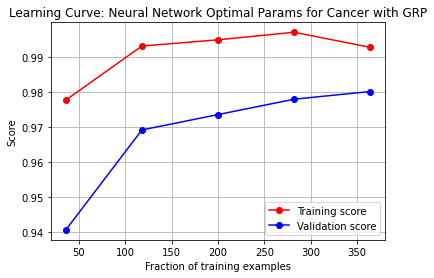

In [29]:
# optimal nn with grp
best_net_GRP = MLPClassifier(activation='relu',
                             hidden_layer_sizes=(30, 15), 
                             max_iter=500,
                             random_state=id, 
                             solver='adam',
                             alpha=0.1,
                             learning_rate='invscaling')

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net_GRP, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network Optimal Params for Cancer with GRP')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_optimal_params_GRP_learning_curve.png')

In [30]:
best_net_GRP.fit(X_train, y_train)
print ('classification report + confusion matrix for NN + RP')
print ()
test_predictions = best_net_GRP.predict(X_test)
print(classification_report(y_test, test_predictions, digits=3))
print(confusion_matrix(y_test, test_predictions))

classification report + confusion matrix for NN + RP

              precision    recall  f1-score   support

         0.0      0.932     0.986     0.958        70
         1.0      0.975     0.886     0.929        44

    accuracy                          0.947       114
   macro avg      0.954     0.936     0.943       114
weighted avg      0.949     0.947     0.947       114

[[69  1]
 [ 5 39]]


# Neural Network + GRP + Kmean

In [35]:
# neural nets with dimensionality reduction & clustering
neural_net = MLPClassifier()
neural_net.fit(cancerX_df, cancerY)

cancer_train_pred = neural_net.predict(cancerX_df)
accuracy = accuracy_score(cancerY, cancer_train_pred)
print('The accuracy score for benchmark is', round(accuracy,4))
print()
print(classification_report(cancerY, cancer_train_pred))

The accuracy score for benchmark is 0.9789

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       357
         1.0       0.99      0.96      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.97      0.98       569
weighted avg       0.98      0.98      0.98       569



In [36]:
X_train, X_test, y_train, y_test = train_test_split(cancerX_df, cancerY, test_size=0.2, random_state=id)

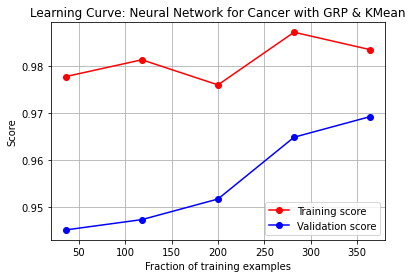

In [37]:
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(neural_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network for Cancer with GRP & KMean')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_GRP_Kmean_learning_curve.png')

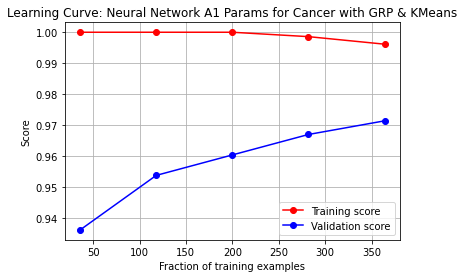

In [38]:
# use parameters from Assignment 1
best_net = MLPClassifier(activation='relu',
                         hidden_layer_sizes=(30,),
                         learning_rate_init=0.01, 
                         max_iter=500,
                         random_state=id, 
                         solver='adam', 
                         alpha=0.0001)

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network A1 Params for Cancer with GRP & KMeans')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_A1_params_GRP_Kmean_learning_curve.png')
plt.show()

In [39]:
# check optimal parameters for nn & pca & clustering
param_grid = {'hidden_layer_sizes': [(15,), (15, 7), (30, ), (30, 15)],
              'alpha' : [0.1, 0.01, 0.001],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

search_f1 = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=4)
search_f1.fit(X_train, y_train)
print(search_f1.best_estimator_, search_f1.best_score_)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 15),
              learning_rate='invscaling') 0.9824175824175825


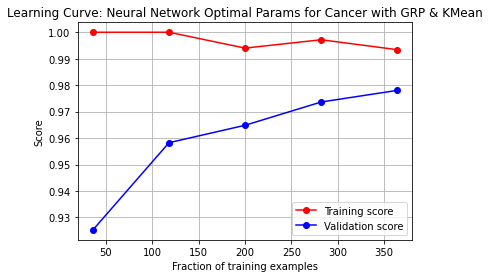

In [40]:
best_net_GRP = MLPClassifier(activation='relu',
                             hidden_layer_sizes=(30, 15), 
                             max_iter=500,
                             random_state=id, 
                             solver='adam', 
                             alpha=0.01, 
                             learning_rate='invscaling')

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net_GRP, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network Optimal Params for Cancer with GRP & KMean')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_optimal_params_GRP_Kmean_learning_curve.png')
plt.show()

In [41]:
best_net_GRP.fit(X_train, y_train)
test_predictions = best_net_GRP.predict(X_test)
print(classification_report(y_test, test_predictions, digits=3))
print(confusion_matrix(y_test, test_predictions))

              precision    recall  f1-score   support

         0.0      0.944     0.971     0.958        70
         1.0      0.952     0.909     0.930        44

    accuracy                          0.947       114
   macro avg      0.948     0.940     0.944       114
weighted avg      0.948     0.947     0.947       114

[[68  2]
 [ 4 40]]
